# Generate results plot from raw data

Imports

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.metrics import mean_squared_error

Read raw data

In [254]:
df = pd.read_csv("../results/raw_data.csv")

def get_stimulus_score(df: pd.DataFrame, prefix: str) -> np.ndarray:
    cols = [col for col in df.columns if col.strip().startswith(prefix)]
    data = df[cols].apply(pd.to_numeric, errors='coerce').fillna(0)
    return data.sum(axis=0).values

plot_data_kwargs = {
    "Drum": {
        "ans": get_stimulus_score(df, "Drum"),
        "x_axis": np.array([50, 100, 150, 200, 250, 300, 350]),
        "x_ticks": [50, 10],
    },
    "Vocal": {
        "ans": get_stimulus_score(df, "Vocal"),
        "x_axis": np.array([10, 20, 30, 40, 50, 60, 70]),
        "x_ticks": [10, 2],
    },
    "Flute": {
        "ans": get_stimulus_score(df, "Flute"),
        "x_axis": np.array([1, 3, 5, 7, 9, 11, 13]),
        "x_ticks":  [[2, 1], [0.4, 1]],
    },
}
for stimuli, data in plot_data_kwargs.items():
    prefix = stimuli
    n_answers = df[[col for col in df.columns if col.strip().startswith(prefix)]].notna().any(axis=1).sum()
    data["n_answers"] = n_answers
    data["y_axis"] = data["ans"] / n_answers * 100
    data["confidence_line"] = (n_answers / 2 + np.sqrt(n_answers)) * 100 / n_answers
    

Define function to plot results

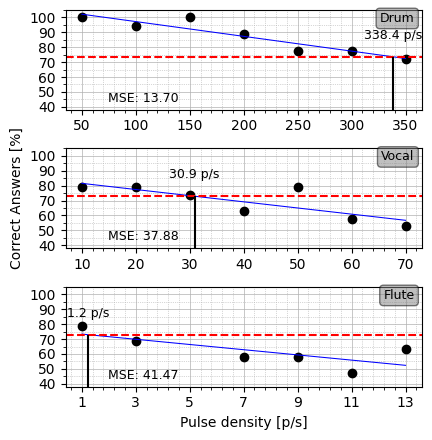

In [255]:
def get_locator(val):
    if isinstance(val, (list, tuple)):
        return MultipleLocator(*val)
    else:
        return MultipleLocator(val)

def plot_results(ax, label, data):

    major_locator, minor_locator = data["x_ticks"]

    ax.set_axisbelow(True)
    ax.set_ylim(38, 105)
    ax.grid(which='major', linestyle='-', linewidth=0.5)
    ax.grid(which='minor', linestyle=':', linewidth=0.5)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    ax.yaxis.set_minor_locator(MultipleLocator(5))
    ax.xaxis.set_major_locator(get_locator(major_locator))
    ax.xaxis.set_minor_locator(get_locator(minor_locator))
    
    x = data["x_axis"]
    y = data["y_axis"]
    # Remove outlier on flute stimulus
    if label == "Flute":
        x = np.delete(x, 2)
        y = np.delete(y, 2)
    
    if label == "Vocal":
        ax.set_ylabel("Correct Answers [%]")
    
    ax.scatter(x, y, c='k', label=label)

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    ax.plot(x, p(x), "b", linewidth=0.75)
    
    confidence = data["confidence_line"]
    ax.axhline(y=confidence, color='r', ls='--')
    
    # Vertical intersection line from y=bottom to confidence level
    slope, intercept = z
    if slope != 0:
        x_int = (confidence - intercept) / slope
        y_min = ax.get_ylim()[0]
        ax.vlines(x_int, ymin=y_min, ymax=confidence, color='black', linestyle='-')
        ax.text(x_int, confidence + 10, f"{x_int:.1f} p/s", color='black',
                fontsize=9, ha='center', va='bottom')

    mse = mean_squared_error(y, p(x))
    ax.text(0.12, 0.05, f'MSE: {mse:.2f}', fontsize=9, transform=ax.transAxes,
            verticalalignment='bottom', horizontalalignment='left')
    
    ax.text(0.98, 0.85, label, fontsize=9, transform=ax.transAxes,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='gray', alpha=0.5))
        
    
fig, axs = plt.subplots(3, 1, figsize=(4.5, 4.5), sharey=True)

for ax, (stimulus, data) in zip(axs, plot_data_kwargs.items()):
    plot_results(ax, stimulus, data)

ax.set_xlabel("Pulse density [p/s]")

plt.subplots_adjust(right=0.7, hspace=0.3)
plt.tight_layout()
plt.show()

